<a href="https://colab.research.google.com/github/lakshmipriyaanand/nn-zero-to-hero-andrej-notes/blob/main/Building_Makemore_2_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Makemore with MLP

Bigram helps us to predict the next character by viewing the 1 character before it. Now we are going to try to predict the next character by viewing many characters before it.

Now we are going to have a vocabulary size of 17,000 embedded into a 30 dimensional space. i.e we are going to have 17,000 points or vectors in a 30 dimensional space using a Multi Layer Neural Network. They can be tuned by **maximizing the log-likelihood of the training data (by adding weights)**. We'll have a lookup table 17000 x 30. We'll follow the same steps as bigram NN but modify here accordingly for multiple neurons

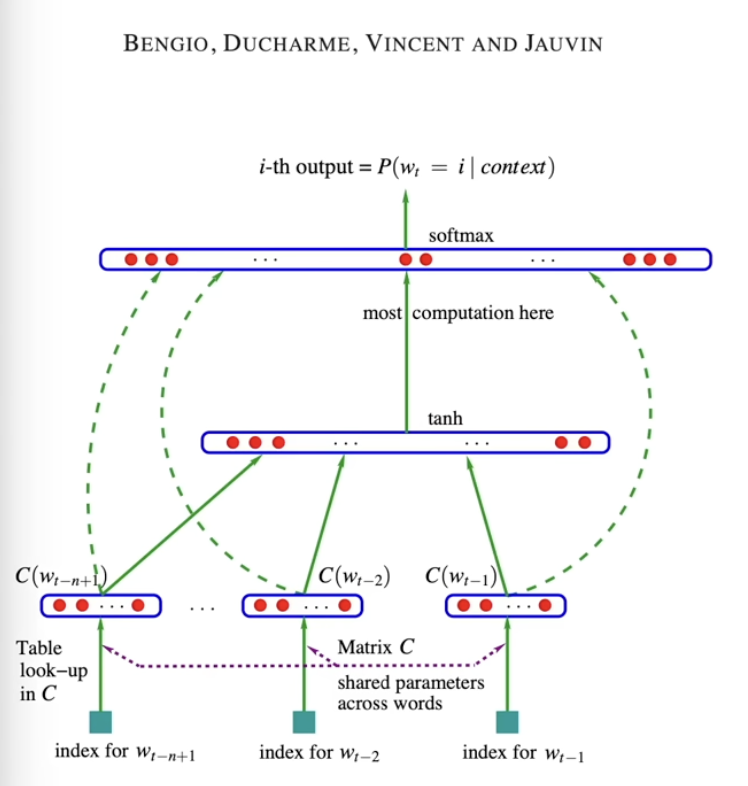

In [1]:
#Makemore with MLP
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
#Importing dataset from our Github repo
import requests
url = "https://raw.githubusercontent.com/lakshmipriyaanand/makemore_LP/refs/heads/main/names.txt"
data = requests.get(url).text #downloads the file from github
words = data.splitlines() #splits it into a list of lines, just like reading a local file
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Build the dataset

## Train-test split

Dataset is split into 3:

- train split: 80% of Dataset - to train the parameter
- Dev/Validation split : 10% of Dataset - to train and check the hyperparameter on how each changes made in hyperparameter result
- test split: 10% of Dataset - to check the performance . Perform this only few times to prevent overfitting

In [68]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


# Embed


1) What is embedding?

Every character is converted into numbers (a vector).
This vector is called an embedding.

Example:
Character 'a' → [0.2, -0.5, 1.3]
Character 'b' → [1.1, 0.4, -0.8]

In [16]:
C = torch.randn((27, 2))
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [17]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

✅ Visual Example

Let’s assume:

***batch_size*** = 2
***block_size*** = 3
**embedding_dim** = 4

Then:

emb.shape = (2, 3, 4)


Meaning:

2 examples -> each has 3 characters context -> each character is embedding of size 4


**Let’s draw:**

emb =
[
   
    [[a1,a2,a3,a4],   ← char 1 of example 1

    [b1,b2,b3,b4],   ← char 2 of example 1

    [c1,c2,c3,c4] ], ← char 3 of example 1


   
    [[d1,d2,d3,d4],   ← char 1 of example 2

    [e1,e2,e3,e4],   ← char 2 of example 2
    
    [f1,f2,f3,f4] ]  ← char 3 of example 2
]


You feed characters →
embedding layer converts them → vectors

You group multiple examples → batch
Each example uses last few chars → block
Each char gives feature vector → embedding_dim


# Embed concat

✅ 1) What is emb[:, i, :] ?

Let emb.shape = (2, 3, 4)

emb[:, 0, :] → first position in context → shape = (B, C) = (2, 4)

emb[:, 1, :] → second position → shape = (2, 4)

emb[:, 2, :] → third position → shape = (2, 4)

Each is a 2×4 matrix.

So:

emb[:,0,:]  → (2,4)
emb[:,1,:]  → (2,4)
emb[:,2,:]  → (2,4)

✅ What does torch.cat([...], dim=1) do?
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1)


We join them horizontally (dim=1):

So (2,4) + (2,4) + (2,4)
→ becomes (2, 12)

✅ New shape:

(2, 3*4) == (B, T*C)


So this “flattens” the 3 time positions into one long vector.

In [18]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1) .shape #Concats all three

torch.Size([228146, 6])

# Embed unbind

**Let’s use a tiny example:**

B = 2   (2 examples in batch)

T = 3   (3 positions in context)

C = 2   (embedding size 2)

emb =

[

  [ [1,2], [3,4], [5,6] ],   # Example 1

  [ [7,8], [9,10], [11,12] ] # Example 2

]



**1️⃣ torch.unbind(emb, 0) → split batch**

- Takes one example at a time

- Returns 2 tensors (because B=2)

- Each tensor = shape (T, C) = (3,2)

    Tensor 1 → [[1,2],[3,4],[5,6]]

    Tensor 2 → [[7,8],[9,10],[11,12]]


**Think: “one whole example per tensor” ✅**



**2️⃣ torch.unbind(emb, 1) → split time/block**

- Takes one position in context at a time

- Returns 3 tensors (because T=3)

- Each tensor = shape (B, C) = (2,2)

  Tensor 1 → pos0 for all batches = [[1,2],[7,8]]

  Tensor 2 → pos1 = [[3,4],[9,10]]

  Tensor 3 → pos2 = [[5,6],[11,12]]


**Think: “all batches, same position” ✅**

This is the one we use to flatten context embeddings into a single vector per example.


**3️⃣ torch.unbind(emb, 2) → split embedding/features**

- Takes one feature at a time

- Returns 2 tensors (because C=2)

- Each tensor = shape (B, T) = (2,3)

  Tensor 1 → feature0 for all batches and positions = [[1,3,5],[7,9,11]]

  Tensor 2 → feature1 = [[2,4,6],[8,10,12]]


**Think: “look at one feature across all positions” ✅**

Rarely used in practice — usually embeddings stay together.

# Embed Concat+Unbind

1️⃣ Step 1 — torch.unbind(emb, 1)

- dim=1 → split along time/block axis

- Returns T tensors (one for each position in context)

- Each tensor shape = (B, C)

- Example (tiny numbers):

  B = 2, T = 3, C = 2

  emb =
  
  [

  [  [1,2], [3,4], [5,6] ],   # example 1

  [   [7,8], [9,10], [11,12] ] # example 2

  ]

torch.unbind(emb,1) →

(
    [[1,2],[7,8]],   # pos0

    [[3,4],[9,10]],  # pos1

    [[5,6],[11,12]]  # pos2
)


**Think: “take each position in the context for all batches” ✅**


2️⃣ Step 2 — torch.cat(..., 1)

- Now we have a tuple of T tensors (B, C) each

- Concatenate along dim=1 (the feature axis)

  torch.cat([ [1,2],[3,4],[5,6] for example1 ]) → [1,2,3,4,5,6]


Shape after cat → (B, T*C)

Result =
[
  
    [1,2,3,4,5,6],     # example 1

    [7,8,9,10,11,12]   # example 2
]


✅ Each example now has all context positions flattened into one vector

In [19]:
torch.cat(torch.unbind(emb,1),1)

tensor([[ 2.1040,  1.4934,  2.1040,  1.4934,  2.1040,  1.4934],
        [ 2.1040,  1.4934,  2.1040,  1.4934,  0.4210,  0.8655],
        [ 2.1040,  1.4934,  0.4210,  0.8655,  1.1861,  1.0918],
        ...,
        [ 1.3342, -0.9799,  0.4210,  0.8655,  0.0777, -0.0299],
        [ 0.4210,  0.8655,  0.0777, -0.0299, -1.0060, -0.4442],
        [ 0.0777, -0.0299, -1.0060, -0.4442,  0.4719, -0.5221]])

✅ Key Intuition

unbind(dim=1) → pull out each position in context

cat(dim=1) → glue them together to form one long vector per example

This is exactly what we do before a linear layer in a character-level model.

## Important note:

".cat" creates new storage so new memory is being created because there's no way to concat tensors just by manipulating the view attributes. So basically its in-efficient and creates all kinds of new memory.

## Basic torch functionality describe

In [20]:
#Basic describe

a=torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [21]:
a.shape

torch.Size([18])

In [22]:
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [23]:
a.view(3,3,2)

#View them in the particular dimension

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

View is extremely efficient in pytorch tensor as in each tensor there's something called "underlying storage". Storage is always a one-dimensonal vector and below is how the tensor is represented in the computer memory.

But in a.view() we are manipulating some of the attributes of that tensor that dictate how the one-dimensional sequence is interpreted to be an 'n-dimensional' tensor.

In [24]:
a.storage()

/tmp/ipython-input-214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [25]:
emb.shape #Basic shape

torch.Size([228146, 3, 2])

In [26]:
emb.view(228146,6) #Viewing in this format

tensor([[ 2.1040,  1.4934,  2.1040,  1.4934,  2.1040,  1.4934],
        [ 2.1040,  1.4934,  2.1040,  1.4934,  0.4210,  0.8655],
        [ 2.1040,  1.4934,  0.4210,  0.8655,  1.1861,  1.0918],
        ...,
        [ 1.3342, -0.9799,  0.4210,  0.8655,  0.0777, -0.0299],
        [ 0.4210,  0.8655,  0.0777, -0.0299, -1.0060, -0.4442],
        [ 0.0777, -0.0299, -1.0060, -0.4442,  0.4719, -0.5221]])

In [27]:
emb.view(228146,6) == torch.cat(torch.unbind(emb,1),1) #Checking whether it returns the same value as cat,unbind over emb . It returns true

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        ...,
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

# -------------- Now enough of other learningssss and focus --------------

In [28]:
#Once we build the dataset, come here!

C = torch.randn((27,2))
emb= C[X]
emb.shape

torch.Size([228146, 3, 2])

In [29]:
W1=torch.randn((6,100))
b1=torch.randn(100)

In [30]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[ 0.8737, -0.9975,  0.9112,  ..., -0.9942,  0.6030, -0.9939],
        [ 0.9955, -0.9991,  0.9483,  ..., -0.9830,  0.5402,  0.3603],
        [ 0.7639,  0.8341,  0.0122,  ...,  0.0749, -0.8894, -0.0862],
        ...,
        [ 1.0000, -0.6729,  0.3196,  ..., -1.0000, -1.0000, -0.7048],
        [-0.4489, -0.9668, -0.4386,  ..., -0.9986,  0.8697, -0.9946],
        [ 0.6547, -1.0000,  0.9495,  ..., -0.9995,  1.0000, -0.9943]])

**For emb.view(-1,6):**

-1 tells PyTorch:

“I don’t care what this dimension should be —
infer it automatically based on the remaining size.”

6 means:

Make the last dimension size = 6

In [31]:
h.shape

torch.Size([228146, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

Once weights and bias are initialised, we'll go for forward pass initialisation. logits,counts,probs are a part of forward pass as same as bigram model. Here counts and probs are softmax part.

In [ ]:
logits = h @ W2 + b2
logits.shape

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
prob.shape

In [ ]:
loss = -prob[torch.arange(228146), Y].log().mean() #Finding negative loss likelihood value
loss

# Now more neat and expectable format

In [69]:
Xtr.shape, Ytr.shape # dataset


(torch.Size([182441, 3]), torch.Size([182441]))

In [84]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
n_hidden = 400 #no. of neurons inside hidden layer
W1 = torch.randn((30, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] #Clustered all the paramters into single list of parameters

In [75]:
sum(p.nelement() for p in parameters) # number of parameters in total

17697

In [85]:
for p in parameters:
  p.requires_grad = True

## Pytorch will prefer F.cross_entropy more than 'counts,prob,loss' :

- as they create seperate vectors for each. cross_Entropy has a cluster/infused kernals that very efficiently combines the work of all three in the above.

- Forward and Backward pass is more efficient not becoz of the infused kernal but more analytically and mathematically more simplified.

- They behave more well numerically

In [77]:
#initialising learning rate

lre = torch.linspace(-3, 0, 1000)  #Each value here represents an exponent. Learning rate exponent - generates 1000 evenly spaced numbers between -3 and 0 eg: [-3.0000, -2.9970, -2.9940, ..., -0.0030, 0.0000]
lrs = 10**lre #converts the exponents into actual learning rates.a tensor of 1000 learning rates spaced logarithmically between 0.001 and 1.
lri = [] #Tracking learning rate we used
lossi = [] #Tracking loss we get
stepi = [] #Tracking step

In [86]:

for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) #ix will be a 1D tensor containing 32 random integers between 0 and X.shape[0] - 1.Typically, this is used to randomly select a batch of 32 samples from X.

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 300)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix]) #Instead of finding 'counts,prob,loss' we are using a single line where we pass logits and target array y
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update -- for gradients
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad #so we started with very low learning rate till -1.0

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

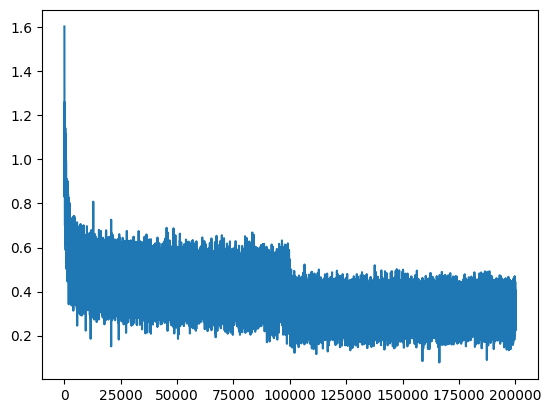

In [87]:
plt.plot(stepi, lossi)

In [88]:
# Loss value for train split

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1064, grad_fn=<NllLossBackward0>)

In [89]:
#Finding loss for dev/validation split

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1815, grad_fn=<NllLossBackward0>)

In [90]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1841, grad_fn=<NllLossBackward0>)

### We can see the training and validation loss are roughly equal. So it is underfitting. So increasing the neural network size

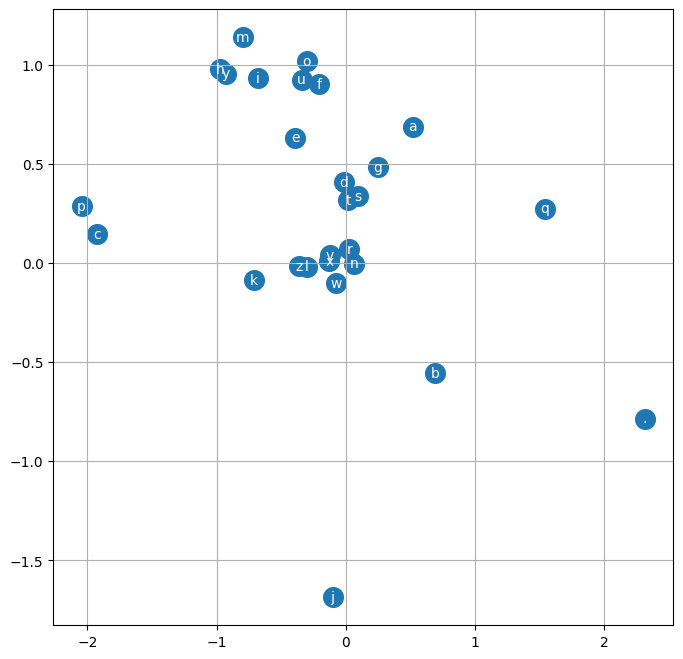

In [91]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [92]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carmah.
amorie.
khy.
myli.
taty.
halayslee.
zhunna.
perric.
kaqui.
ner.
ken.
chaiiv.
kaleigh.
ham.
powe.
quint.
shonora.
jadii.
wazell.
dearyni.
